In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfanme","key":"fa3fac860fa3de1e829f7441c419e299"}'}

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d alfanme/indonesian-batik-motifs-corak-app

 88% 138M/156M [00:01<00:00, 103MB/s] 
100% 156M/156M [00:01<00:00, 133MB/s]


In [4]:
!unzip -qq /content/indonesian-batik-motifs-corak-app.zip

In [5]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [26]:
train_path = '/content/DATASETv7/TRAIN'
test_path = '/content/DATASETv7/TEST'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

motives_dict = train_generator.class_indices
print(motives_dict)

Found 1050 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Cendrawasih': 2, 'Batik Dayak': 3, 'Batik Geblek Renteng': 4, 'Batik Ikat Celup': 5, 'Batik Insang': 6, 'Batik Kawung': 7, 'Batik Lasem': 8, 'Batik Megamendung': 9, 'Batik Pala': 10, 'Batik Parang': 11, 'Batik Poleng': 12, 'Batik Sekar Jagad': 13, 'Batik Tambal': 14}


In [53]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg'
)

base_model.trainable = False

In [54]:
def scheduler(epoch, lr):
  if epoch <= 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [55]:
EPOCHS = 30
LEARNING_RATE = 1e-4
TRAIN_STEP = 1050//30
VAL_STEP = 300//30

In [57]:
clear_session()

model = Sequential([
    base_model,
    Dense(150, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.25),
    Dense(15, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 150)               192150    
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                2265      
Total params: 2,452,399
Trainable params: 194,415
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 19s 480ms/step - loss: 3.1381 - accuracy: 0.0952 - val_loss: 2.6113 - val_accuracy: 0.1600
Epoch 2/30
35/35 [==============================] - 14s 387ms/step - loss: 2.5896 - accuracy: 0

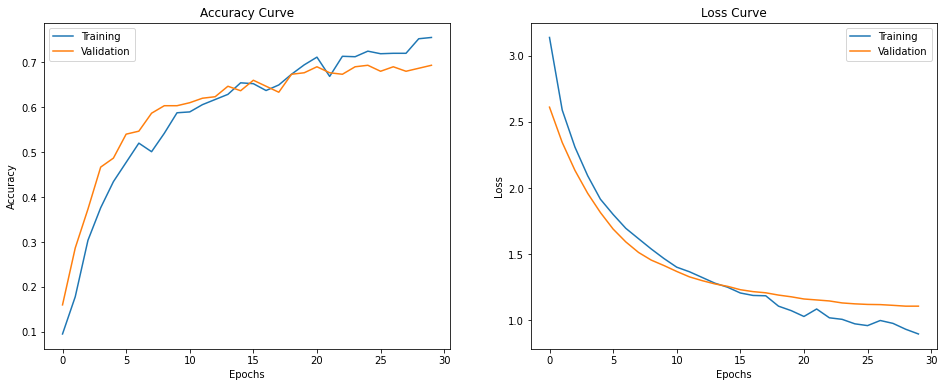

In [58]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [59]:
test_dir = '/content/DATASETv7/TEST/'

for motive in motives_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, motive))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/DATASETv7/TEST/{motive}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        motives_list = list(motives_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == motive:
            correct_count += 1

        # plt.subplot(5, 4, idx+1)
        # plt.title(f'Actual: {motive}\nPrediction: {pred_motive} {pred_confidence:.2f}%')
        # plt.imshow(img)
        # plt.axis('off')
    
    print(f'{motive} Predictions --> {correct_count}/20 correct')
# plt.show()

Batik Bali Predictions --> 11/20 correct
Batik Betawi Predictions --> 9/20 correct
Batik Cendrawasih Predictions --> 15/20 correct
Batik Dayak Predictions --> 16/20 correct
Batik Geblek Renteng Predictions --> 11/20 correct
Batik Ikat Celup Predictions --> 13/20 correct
Batik Insang Predictions --> 14/20 correct
Batik Kawung Predictions --> 17/20 correct
Batik Lasem Predictions --> 7/20 correct
Batik Megamendung Predictions --> 18/20 correct
Batik Pala Predictions --> 11/20 correct
Batik Parang Predictions --> 16/20 correct
Batik Poleng Predictions --> 18/20 correct
Batik Sekar Jagad Predictions --> 14/20 correct
Batik Tambal Predictions --> 18/20 correct


In [60]:
model_save_path = "saved_model/15_motives"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
os.makedirs('tflite_models')
with open('tflite_models/15_motives.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: saved_model/15_motives/assets


INFO:tensorflow:Assets written to: saved_model/15_motives/assets
